In [1]:
import glob
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config
import torch
from dataloaders.coco17_loader import COCO17Loader
from dataloaders.imagenet_loader import ImageNetLatentLoader
from eval.reconstruction_eval import ReconstructionEval
from generate_new_decoder import generate_from_decoder
from modules.models.decoding.openai_decoder import DiffusionDecoder
from torchvision.utils import save_image
from torchvision.transforms import v2
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

from tqdm import tqdm
import glob
import json 

device = "cuda"
seed = 42
torch.manual_seed(seed)


def ldm_transform_latent(z, extra_scale_factor=1):
    channel_means = [0.38862467, 0.02253063, 0.07381133, -0.0171294]
    channel_stds = [0.9654121, 1.0440036, 0.76147926, 0.77022034]

    if len(z.shape) != 4:
        raise ValueError()

    z = z * 0.18215
    channels = [z[:, i] for i in range(z.shape[1])]

    channels = [
        extra_scale_factor * (c - channel_means[i]) / channel_stds[i]
        for i, c in enumerate(channels)
    ]
    return torch.stack(channels, dim=1)



/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/pg51242/Desktop/te

In [3]:
# ==== VAE ====
# model_config = OmegaConf.load("configs/models/cifar10_model.yaml")
# diffusion_decoder = load_model_from_config(model_config.first_stage_config, "checkpoints/sdxl_vae.safetensors")
# diffusion_decoder = diffusion_decoder.to("cuda")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, device="cuda:0"
)
pipe.unet.cpu()
pipe.vae.cuda()


# ==== Diffusion Decoder ====

model_config = OmegaConf.load("configs/models/consistency_diffusion_decoder.yaml")
diffusion_decoder = instantiate_from_config(model_config.model)
# Load replicated model
cdd = DiffusionDecoder(320)
cdd.load_state_dict(torch.load("cdd_custom.pt"))
cdd = cdd.cuda()
diffusion_decoder.model.diffusion_model = cdd
sampler = instantiate_from_config(model_config.model.params.sampler_config)


Keyword arguments {'device': 'cuda:0'} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Initialized embedder #0: IdentityEncoder with 0 params. Trainable: True


In [31]:
model_config_original = OmegaConf.load("configs/models/consistency_diffusion_decoder.yaml")
diffusion_decoder = instantiate_from_config(model_config_original.model)
diffusion_decoder = diffusion_decoder.load_from_checkpoint(
    # "diffusion_models_sdxl_cdd/10ske6yi/checkpoints/epoch=0-step=2950.ckpt",
    "diffusion_models_sdxl_cdd/r352dig3/checkpoints/epoch=0-step=150.ckpt",
    network_config=model_config_original.model.params.network_config,
    denoiser_config=model_config_original.model.params.denoiser_config,
    conditioner_config=model_config_original.model.params.conditioner_config,
    first_stage_config=model_config_original.model.params.first_stage_config,
    loss_fn_config=model_config_original.model.params.loss_fn_config,
    sampler_config=model_config_original.model.params.sampler_config,
).cuda()

Initialized embedder #0: IdentityEncoder with 0 params. Trainable: True
Initialized embedder #0: IdentityEncoder with 0 params. Trainable: True


RuntimeError: Error(s) in loading state_dict for DiffusionEngine:
	Unexpected key(s) in state_dict: "loss_fn.lpips.scaling_layer.shift", "loss_fn.lpips.scaling_layer.scale", "loss_fn.lpips.net.slice1.0.weight", "loss_fn.lpips.net.slice1.0.bias", "loss_fn.lpips.net.slice1.2.weight", "loss_fn.lpips.net.slice1.2.bias", "loss_fn.lpips.net.slice2.5.weight", "loss_fn.lpips.net.slice2.5.bias", "loss_fn.lpips.net.slice2.7.weight", "loss_fn.lpips.net.slice2.7.bias", "loss_fn.lpips.net.slice3.10.weight", "loss_fn.lpips.net.slice3.10.bias", "loss_fn.lpips.net.slice3.12.weight", "loss_fn.lpips.net.slice3.12.bias", "loss_fn.lpips.net.slice3.14.weight", "loss_fn.lpips.net.slice3.14.bias", "loss_fn.lpips.net.slice4.17.weight", "loss_fn.lpips.net.slice4.17.bias", "loss_fn.lpips.net.slice4.19.weight", "loss_fn.lpips.net.slice4.19.bias", "loss_fn.lpips.net.slice4.21.weight", "loss_fn.lpips.net.slice4.21.bias", "loss_fn.lpips.net.slice5.24.weight", "loss_fn.lpips.net.slice5.24.bias", "loss_fn.lpips.net.slice5.26.weight", "loss_fn.lpips.net.slice5.26.bias", "loss_fn.lpips.net.slice5.28.weight", "loss_fn.lpips.net.slice5.28.bias", "loss_fn.lpips.lin0.model.1.weight", "loss_fn.lpips.lin1.model.1.weight", "loss_fn.lpips.lin2.model.1.weight", "loss_fn.lpips.lin3.model.1.weight", "loss_fn.lpips.lin4.model.1.weight". 

In [3]:
sampler = instantiate_from_config(model_config_original.model.params.sampler_config)


In [22]:
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sdxl-vae",
).cuda()


In [23]:
loader = COCO17Loader(4, 10, crop=True, test_frac=0.0, shuffle=False, dims=(256, 256), latents_subdir="val2017_latents_sdxl_256/")


In [29]:

with torch.no_grad():
    recon_evaluator = ReconstructionEval("cuda")
    smpls = torch.Tensor([]).to("cpu")
    orig = torch.Tensor([]).to("cpu")
    metrics = {
        "lpips": [],
        "ssim": [],
        "fid": [],
        "psnr": []
    }
    i = 0
    h = 0
    for dl_batch in tqdm(loader.train_dataloader()):
        print(dl_batch["ltnt"].shape)
        samples_cdd = generate_from_decoder(diffusion_decoder, diffusion_decoder.sampler,
            dl_batch["ltnt"].cuda())
        samples_vae = vae.decode(dl_batch["ltnt"].cuda()).sample.clamp(-1, 1)
        samples_vae = torch.clamp((samples_vae + 1.0) / 2.0, min=0.0, max=1.0)
        # print(samples.shape, samples.min(), samples.max())
        # save_image(samples.to("cpu").float(), 'vae_out.png')

        # exit()
        orig_images = torch.clamp((dl_batch["jpg"] + 1.0) / 2.0, min=0.0, max=1.0).cuda()
        break

  0%|          | 0/1250 [00:00<?, ?it/s]

torch.Size([4, 4, 32, 32])


/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
  0%|          | 0/1250 [01:32<?, ?it/s]


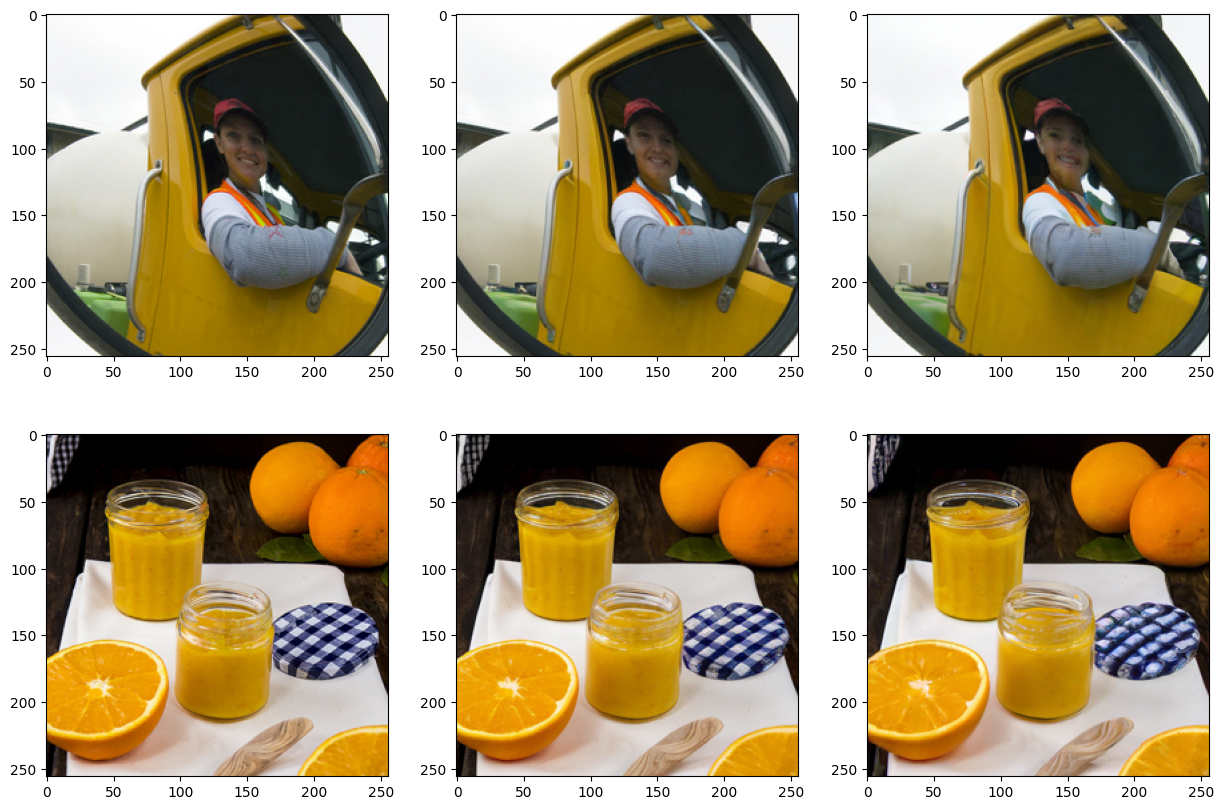

In [30]:
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(2, 3, 1)
plt.imshow(orig_images[0].cpu().float().numpy().transpose(1, 2, 0))
ax2 = fig.add_subplot(2, 3, 2)
plt.imshow(samples_vae[0].cpu().float().numpy().transpose(1, 2, 0))
ax3 = fig.add_subplot(2, 3, 3)
plt.imshow(samples_cdd[0].cpu().float().numpy().transpose(1, 2, 0))

ax1 = fig.add_subplot(2, 3, 4)
plt.imshow(orig_images[1].cpu().float().numpy().transpose(1, 2, 0))
ax2 = fig.add_subplot(2, 3, 5)
plt.imshow(samples_vae[1].cpu().float().numpy().transpose(1, 2, 0))
ax3 = fig.add_subplot(2, 3, 6)
plt.imshow(samples_cdd[1].cpu().float().numpy().transpose(1, 2, 0))

In [16]:
recon_evaluator.update_fid(samples_vae, orig_images)

evals = recon_evaluator(samples_vae.float(), orig_images.float())
metrics["lpips"].append(evals["lpips"])
metrics["psnr"].append(evals["psnr"])
metrics["ssim"].append(evals["ssim"])
metrics


{'lpips': [tensor(0.0696, device='cuda:0', grad_fn=<DivBackward0>)],
 'ssim': [tensor(0.8753, device='cuda:0')],
 'fid': [],
 'psnr': [tensor(27.5088, device='cuda:0')]}

In [ ]:
plt.imshow(samples.cpu().numpy()[0].transpose(1, 2, 0))